## Accessing the project directory on my Google Drive

In [1]:
import os
from google.colab import drive

drive.mount('/drive', force_remount=False)

Mounted at /drive


In [2]:
project_dir = "/drive/My Drive/RNN_seq2seq"

# change working directory to project_dir
os.chdir(project_dir)

In [3]:
from os.path import join


results_folder = "experiments/RESULTS"
os.makedirs(results_folder, exist_ok=True)

plots_folder = join(results_folder, "plots")
os.makedirs(plots_folder, exist_ok=True)

# Statistics

## Get all and best main results across all tasks

In [4]:
import pandas as pd

In [5]:
def get_main_res_df(task_name):
    main_res_fp = f"experiments/{task_name}/main_results.csv"
    df = pd.read_csv(main_res_fp)
    return df


def _extract(df, conds):    
    cond = []
    for k, v in conds.items():
        cond.append(df[k] == v)

    cond = list(map(all, zip(*cond)))
    out = df[cond]
    return out

In [6]:
all_res = []
best_res = []

gen_weight, test_weight = 0.6, 0.4
cond_metric_name = "Full Sequence Accuracy"
res_col = ["Task Name", "Run #", "RNN", "Attention", 
           "Dataset", "Loss", "Full Sequence Accuracy",
           "First N-symbol Accuracy", "Overlap Rate"]

# in my initial implementation, 
# I did not do per-sequence-length evaluation, hence RE_EVAL
for task_name in ["identity", "rev", "total_red", "input_spec_red_RE_EVAL"]:
    task_res_df = get_main_res_df(task_name)
    
    for rnn_type in ["SRNN", "GRU", "LSTM"]:
        for attn in [True, False]:
            conds = {"RNN": rnn_type, "Attention": attn}
            sub_df = _extract(task_res_df, conds)
            
            best_run_num, best_perf = 1, 0
            for run_num in range(1, 4):
                cur_df = _extract(sub_df, {"Run #": run_num})
                test_perf = cur_df[cur_df.Dataset == "Test"]
                test_perf = test_perf[cond_metric_name].item()
                gen_perf = cur_df[cur_df.Dataset == "Gen"]
                gen_perf = gen_perf[cond_metric_name].item()
                perf = gen_perf * gen_weight + test_perf * test_weight
                
                if perf > best_perf:
                    best_perf = perf
                    best_run_num = run_num

            conds.update({"Run #": best_run_num})
            best_sub_df = _extract(task_res_df, conds)
            best_res.extend([[task_name] + l for l in best_sub_df.to_numpy().tolist()])
    
    task_res_df.insert(0, "Task Name", task_name)
    all_res.append(task_res_df)


all_res_df = pd.concat(all_res)
all_res_df.to_csv(join(results_folder, "all_main_results_all_tasks.csv"), index=False)
best_res_df = pd.DataFrame(best_res, columns=res_col)
best_res_df.to_csv(join(results_folder, "best_main_results_all_tasks.csv"), index=False)

## Get summarized main results

In [7]:
def get_sum_stats(series):
    mx = series.max()
    mn = series.min()
    mean = series.mean()
    std = series.std()
    return [mx, mn, mean, std]

In [8]:
sum_res = []
sum_res_col = ["Task Name", "RNN", "Attention", "Dataset", 
               "Metric", "Max", "Min", "Mean", "Std"]

for task_name in ["identity", "rev", "total_red", "input_spec_red"]:
    for rnn_type in ["SRNN", "GRU", "LSTM"]:
        for attn in [True, False]:
            for ds in ["Train", "Dev", "Test", "Gen"]:
                conds = {"Task Name": task_name, "RNN": rnn_type, 
                         "Attention": attn, "Dataset": ds}
                sub = _extract(all_res_df, conds)
                
                for metric in ["Loss", "Full Sequence Accuracy", 
                               "First N-symbol Accuracy", "Overlap Rate"]:
                
                    mx, mn, mean, std = get_sum_stats(sub[metric])
                    sum_res.append([task_name, rnn_type, attn, ds, metric, mx, mn, mean, std])

sum_res_df = pd.DataFrame(sum_res, columns=sum_res_col)
sum_res_df.to_csv(join(results_folder, "summarized_main_results_all_tasks.csv"), index=False)                  

## Training epochs

In [9]:
from scripts.utils import read_json

In [10]:
def get_epoch_num(log):
    epoch_nums = []
    for k in log:
        if "Epoch#" in k:
            epoch_nums.append(int(k.replace("Epoch#", "")))
    return max(epoch_nums)

In [11]:
train_log_col = ["Task Name", "RNN", "Attention", "Average", "Run1", "Run2", "Run3"]
train_epochs = []

# training details are in input_spec_red
for task_name in ["identity", "rev", "total_red", "input_spec_red"]:
    for rnn_type in ["SRNN", "GRU", "LSTM"]:
        for attn in ["attn", "attn-less"]:
            runs = []
            for run_num in [1,2,3]:
                fp = f"experiments/{task_name}/{rnn_type}/{attn}/{run_num}/training_log.json"
                epoch = get_epoch_num(read_json(fp))
                runs.append(epoch)
             
            runs = [int(sum(runs) / 3)] + runs
            train_epochs.append([task_name, rnn_type, attn=="attn"] + runs)

train_epochs_df = pd.DataFrame(train_epochs, columns=train_log_col)
train_epochs_df.to_csv(join(results_folder, "train_epochs.csv"), index=False)

## Per-sequence-length generalization performance

Here we only consider:

- test/gen sets results 
- the best results as defined above (on the basis of the full seq accu in gen set)

Input specified reduplication per length per instruction symbol count is also stored.

In [12]:
import numpy as np

In [13]:
def get_per_len_data(test_js, gen_js, 
                     metric="full sequence accuracy"):
    out = []
    for l in range(1, 6):
        out.append(gen_js[f"Len-{l}"][metric])
    
    for l in range(6, 16):
        out.append(test_js[f"Len-{l}"][metric])
        
    for l in range(16, 31):
        out.append(gen_js[f"Len-{l}"][metric])
    
    return out


def get_input_spec_red_per_len_data(test_js, gen_js, metric, avg=True):
    out = []
    for red_num in range(1, 4):
        t_js = test_js[f"Red-{red_num}"]
        g_js = gen_js[f"Red-{red_num}"]
        out.append(get_per_len_data(t_js, g_js, metric))
        
    for red_num in range(4, 7):
        g_js = gen_js[f"Red-{red_num}"]
        
        sub = []
        for l in range(1, 31):
            sub.append(g_js[f"Len-{l}"][metric])
        out.append(sub)
        
    if avg:
        return np.array(out).mean(axis=0).tolist()
        
    return out

In [14]:
per_len_perf = []
per_len_col = ["Task Name", "Run #", "RNN", "Attention", "Metric"] + [f"L{l}" for l in range(1, 31)]
input_spec_red_per_len_perf = []
input_spec_red_per_len_col = ["Run #", "RNN", "Attention", "Metric", "Red_Num"] + [f"L{l}" for l in range(1, 31)]

for task_name in ["identity", "rev", "total_red", "input_spec_red_RE_EVAL"]:
    for rnn_type in ["SRNN", "GRU", "LSTM"]:
        for attn in ["attn", "attn-less"]:
            
            conds = {"Task Name": task_name, "RNN": rnn_type, "Attention": attn == "attn"}
            run_num = _extract(best_res_df, conds)["Run #"].unique().item()
                
            test_fp = f"experiments/{task_name}/{rnn_type}/{attn}/{run_num}/perfs_test.json"
            gen_fp = f"experiments/{task_name}/{rnn_type}/{attn}/{run_num}/perfs_gen.json"
            test_js = read_json(test_fp)
            gen_js = read_json(gen_fp)
                
            for metric in ["full sequence accuracy", "first n-symbol accuracy", "overlap rate", "loss"]:
                    
                if task_name != "input_spec_red_RE_EVAL":
                    data = get_per_len_data(test_js, gen_js, metric)
                else:
                    data = get_input_spec_red_per_len_data(test_js, gen_js, metric, avg=True)
                    data_per_red_num = get_input_spec_red_per_len_data(test_js, gen_js, metric, avg=False)
                    
                    for run_num, d in enumerate(data_per_red_num):
                        input_spec_red_per_len_perf.append(
                            [run_num, rnn_type, attn=="attn", metric, run_num+1] + d)
                    
                per_len_perf.append([task_name, run_num, rnn_type, attn=="attn", metric] + data)
                

per_len_perf_df = pd.DataFrame(per_len_perf, columns=per_len_col)
per_len_perf_df.to_csv(join(results_folder, "best_res_per_len_perf.csv"), index=False)

input_spec_red_per_len_perf_df = pd.DataFrame(input_spec_red_per_len_perf, 
                                              columns=input_spec_red_per_len_col)
input_spec_red_per_len_perf_df.to_csv(join(results_folder, 
                                           "best_input_spec_red_res_per_len_perf.csv"), index=False)

# Visualization

Based on the "**Per-sequence-length generalization performance**" section.

In [15]:
import matplotlib.pyplot as plt

## Models performance across tasks

In [16]:
def plot_models_perf_across_tasks(metric):
    fig = plt.figure(figsize=(23, 5))
    fig.subplots_adjust(hspace=0.35, wspace=0.2)
    yticks = [i/10 for i in range(11)]
    models = ["SRNN", "GRU", "LSTM"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    tasks = ["identity", "rev", "total_red", "input_spec_red_RE_EVAL"]

    for idx, task_name in enumerate(tasks):
        ax = fig.add_subplot(1, 4, idx+1)

        for rnn_type, c in zip(models, colors):
            for attn, alpha in zip([True, False], [1, 0.25]):
                
                cnds = {"Task Name": task_name, "Metric": metric, 
                        "RNN": rnn_type, "Attention": attn}

                cur = _extract(per_len_perf_df, cnds)
                Y = cur.iloc[0][5:].to_list()   
                ax.plot(range(1, 31), Y, ".-", c=c, alpha=alpha)

        ax.set_xlabel('Input Sequence Length', fontsize=10)
        ax.yaxis.set_ticks(yticks)
        ax.set_ylabel(metric.title(), fontsize=10)
        ax.grid(True, alpha=0.1)

        if task_name == "input_spec_red_RE_EVAL":
            task_name = "input_spec_red"

        ax.set_title(task_name)

    ax.plot([], [], 'o-', c=colors[0], label='SRNN')
    ax.plot([], [], 'o-',  c=colors[1], label='GRU')
    ax.plot([], [], 'o-', c=colors[2], label='LSTM')
    ax.plot([], [], 'o', c='black', alpha=1, label="Attn")
    ax.plot([], [], 'o', c='black', alpha=0.25, label="Attn-less")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    metric = "_".join(metric.split())
    plt.savefig(join(plots_folder, f"models_perf_across_tasks_per_len_{metric}.png"), 
                dpi=600, bbox_inches='tight')
    plt.show()

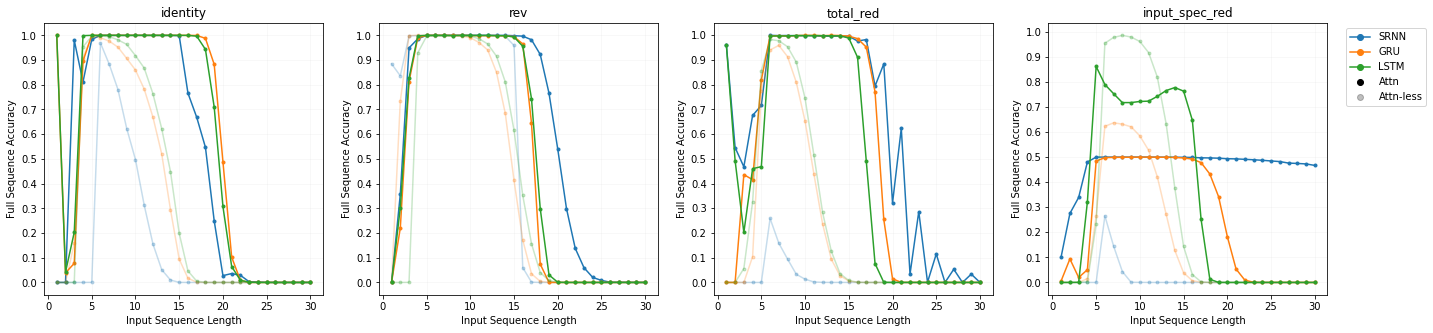

In [17]:
plot_models_perf_across_tasks("full sequence accuracy")

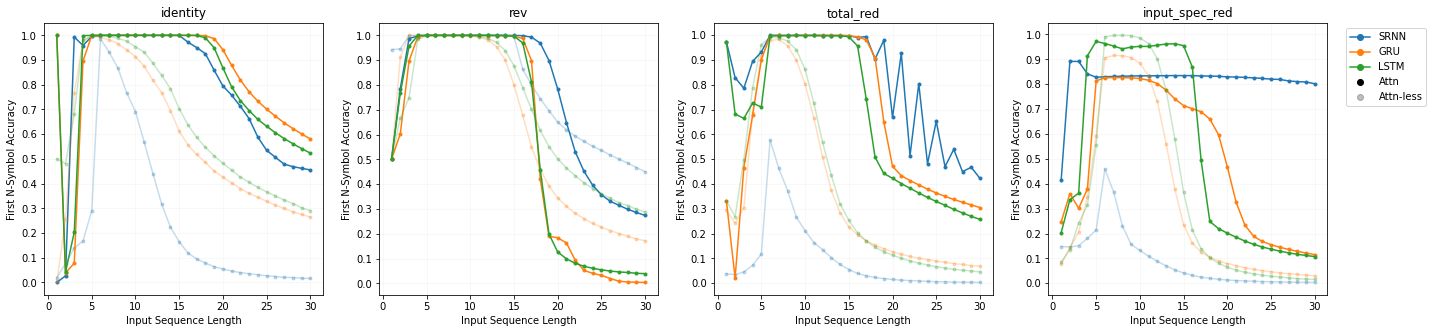

In [18]:
plot_models_perf_across_tasks("first n-symbol accuracy")

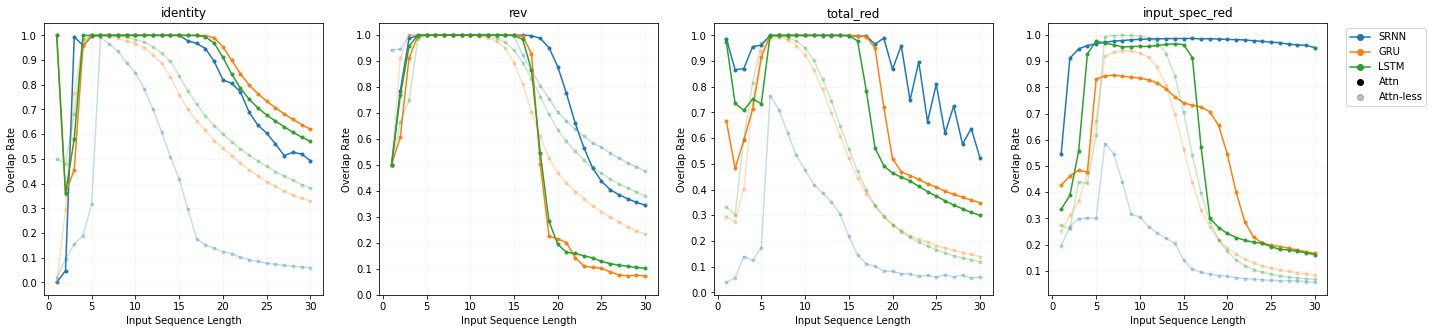

In [19]:
plot_models_perf_across_tasks("overlap rate")

## Tasks performance across models

In [20]:
def plot_tasks_perf_across_models(metric):

    fig = plt.figure(figsize=(23, 6))
    fig.subplots_adjust(hspace=0.35, wspace=0.2)
    yticks = [i/10 for i in range(11)]
    models = ["SRNN", "GRU", "LSTM"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    tasks = ["identity", "rev", "total_red", "input_spec_red_RE_EVAL"]

    for idx, rnn_type in enumerate(models):
        ax = fig.add_subplot(1, 3, idx+1)

        for task_name, c in zip(tasks, colors):
            for attn, alpha in zip([True, False], [1, 0.25]):
                cnds = {"Task Name": task_name, "RNN": rnn_type, 
                        "Attention": attn, "Metric": metric}

                cur = _extract(per_len_perf_df, cnds)
                Y = cur.iloc[0][5:].to_list()   
                ax.plot(range(1, 31), Y, ".-", c=c, alpha=alpha)

        ax.set_xlabel('Input Sequence Length', fontsize=10)
        ax.yaxis.set_ticks(yticks)
        ax.set_ylabel(metric.title(), fontsize=10)
        ax.set_title(rnn_type)
        ax.grid(True, alpha=0.1)

    ax.plot([], [], 'o-', c=colors[0], label='identity')
    ax.plot([], [], 'o-',  c=colors[1], label='rev')
    ax.plot([], [], 'o-', c=colors[2], label='total_red')
    ax.plot([], [], 'o-', c=colors[3], label='input_spec_red')
    ax.scatter([], [], marker='o', c='black', alpha=1, label="Attn")
    ax.scatter([], [], marker='o', c='black', alpha=0.25, label="Attn-less")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    metric = "_".join(metric.split())
    plt.savefig(join(plots_folder, f"tasks_perf_across_models_per_len_{metric}.png"), dpi=600, bbox_inches='tight')
    plt.show()

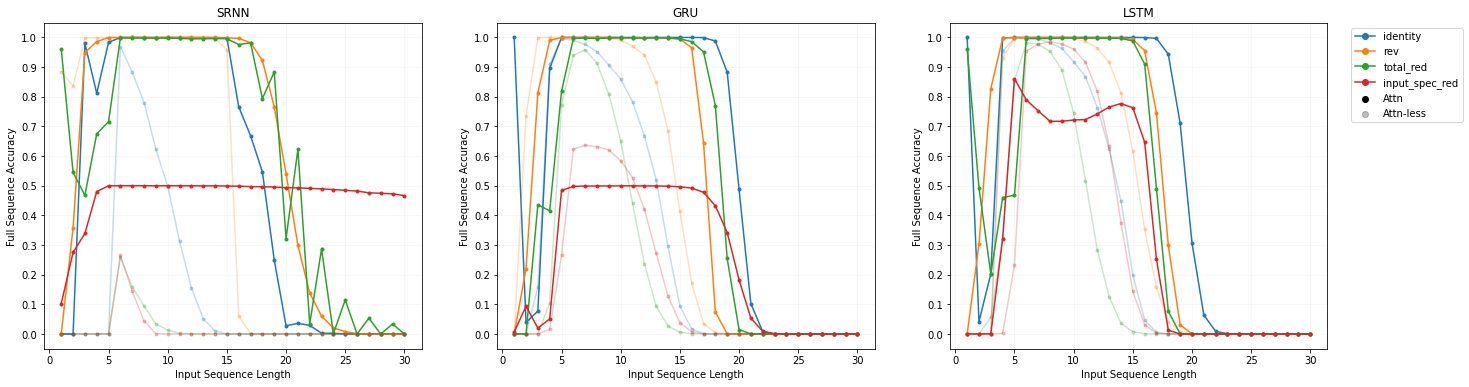

In [21]:
plot_tasks_perf_across_models("full sequence accuracy")

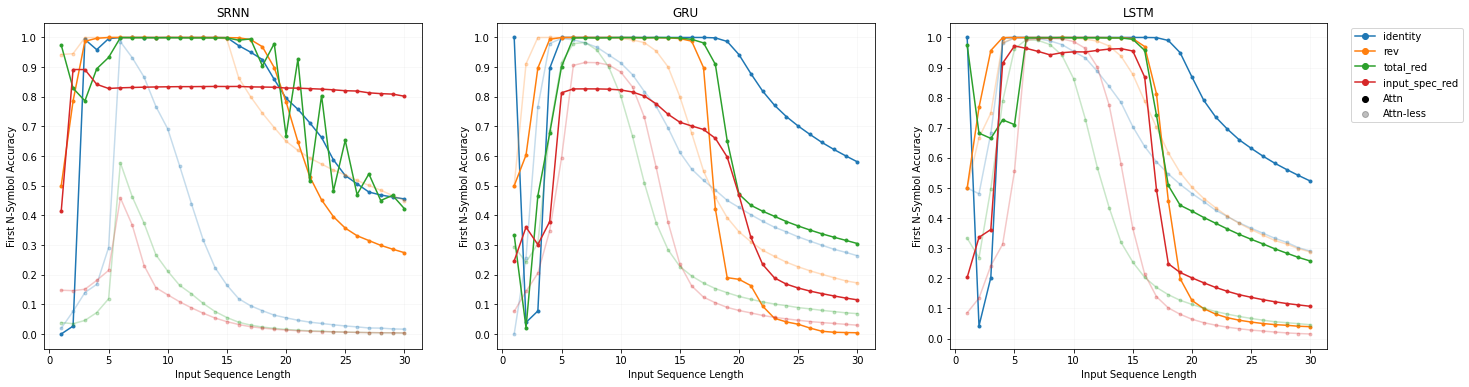

In [22]:
plot_tasks_perf_across_models("first n-symbol accuracy")

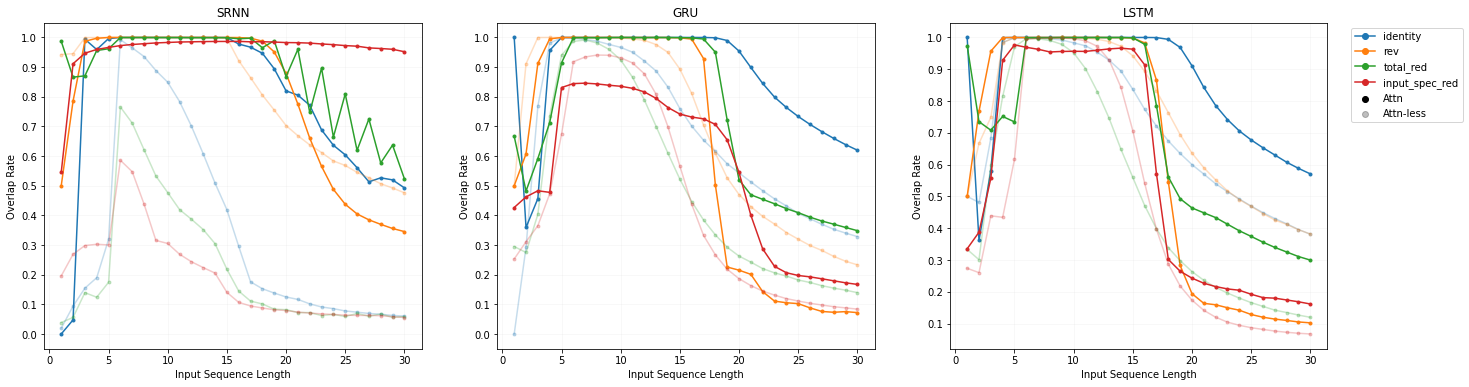

In [23]:
plot_tasks_perf_across_models("overlap rate")

## Input Specified Reduplication

In [24]:
def plot_input_spec_red_across_models(metric):
    fig = plt.figure(figsize=(23, 6))
    fig.subplots_adjust(hspace=0.35, wspace=0.2)
    yticks = [i/10 for i in range(11)]

    models = ["SRNN", "GRU", "LSTM"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 
              '#d62728', '#9467bd', '#8c564b']
    
    for idx, rnn_type in enumerate(models):
        ax = fig.add_subplot(1, 3, idx+1)
        
        for red_num, c in zip([1, 2, 3, 4, 5, 6], colors):
            for attn, alpha in zip([True, False], [1, 0.25]):
                
                cnds = {"RNN": rnn_type, "Attention": attn, 
                        "Metric": metric, "Red_Num": red_num}
                cur = _extract(input_spec_red_per_len_perf_df, cnds)
                Y = cur.iloc[0][5:].to_list()  
                ax.plot(range(1, 31), Y, ".-", c=c, alpha=alpha)
    
        ax.set_xlabel('Input Sequence Length', fontsize=10)
        ax.yaxis.set_ticks(yticks)
        ax.set_ylabel(metric.title(), fontsize=10)
        ax.set_title(rnn_type)
        ax.grid(True, alpha=0.1)
    
    ax.plot([], [], 'o-', c=colors[0], label='Red-1')
    ax.plot([], [], 'o-',  c=colors[1], label='Red-2')
    ax.plot([], [], 'o-', c=colors[2], label='Red-3')
    ax.plot([], [], 'o-', c=colors[3], label='Red-4')
    ax.plot([], [], 'o-', c=colors[4], label='Red-5')
    ax.plot([], [], 'o-', c=colors[5], label='Red-6')

    ax.scatter([], [], marker='o', c='black', alpha=1, label="Attn")
    ax.scatter([], [], marker='o', c='black', alpha=0.25, label="Attn-less")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    metric = "_".join(metric.split())
    plt.savefig(join(plots_folder, f"input_spec_red_per_len_{metric}.png"), dpi=600, bbox_inches='tight')
    plt.show()

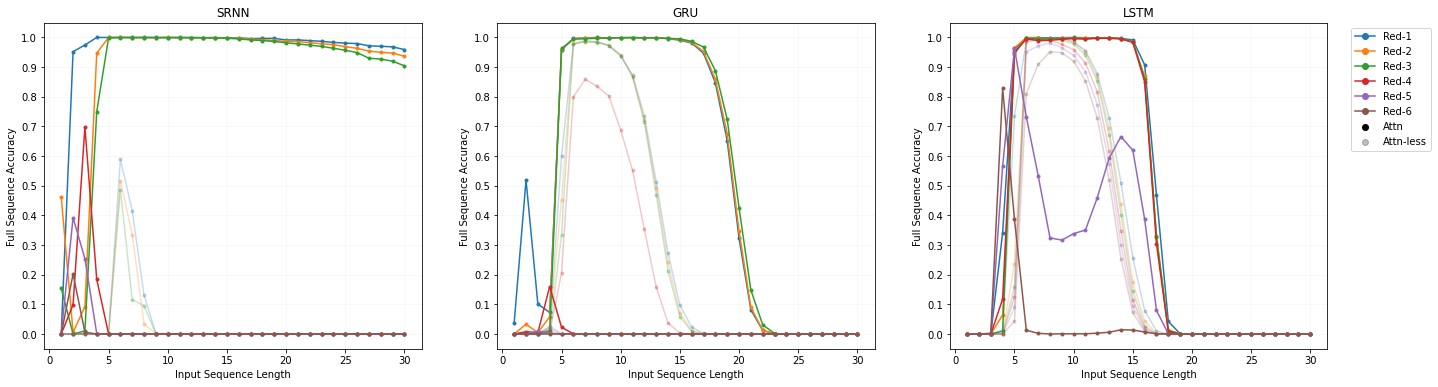

In [25]:
plot_input_spec_red_across_models("full sequence accuracy")

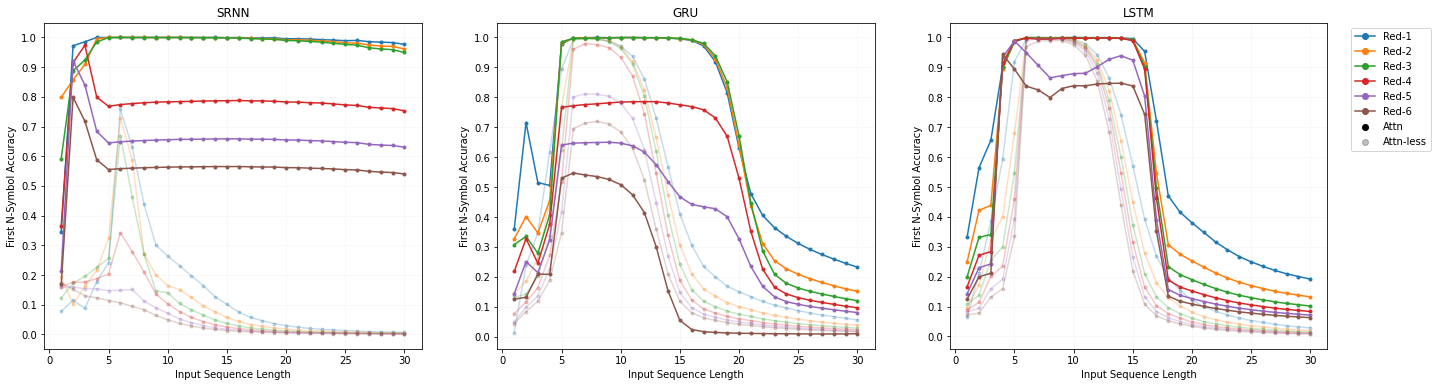

In [26]:
plot_input_spec_red_across_models("first n-symbol accuracy")

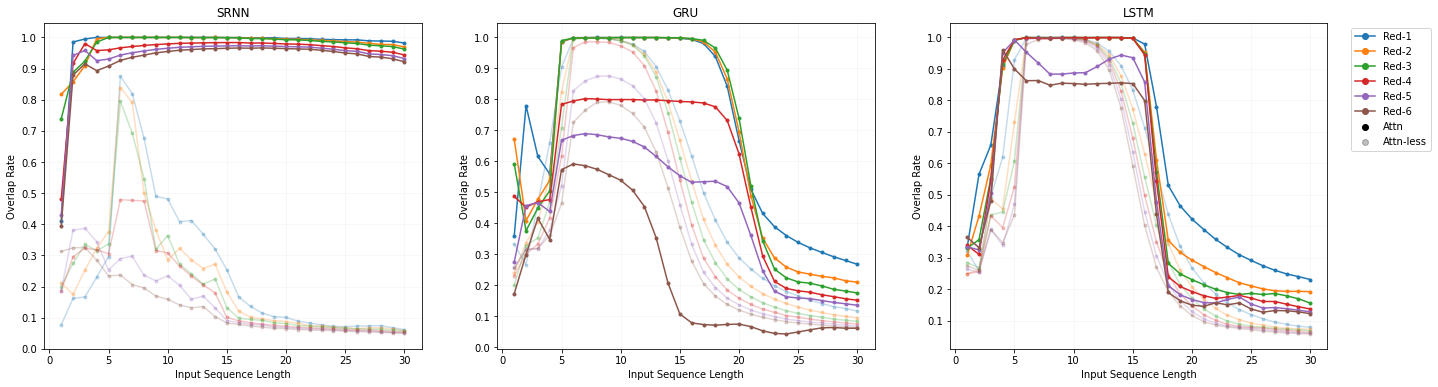

In [27]:
plot_input_spec_red_across_models("overlap rate")